#**HW 3: Convolutional Neural Networks**

In this homework, we will explore how to develop a simple Convolutional Neural Network for image classification. We will use the Fashion Minst dataset. In the first part, we will learn how to develop a simple CNN, while in the second part we will explore the impact of various hyper-parameters in the learning performances.

##Exercise 3.1: Simple CNN

Let's start by importing Tensorflow, Keras and Numpy

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import time

np.random.seed(42)

###Load dataset:
### Load Data: Fashion MNIST dataset

We will use the Fashion MNIST dataset, a dataset of Zalando's articles. Each sample is a 28x28 pixels grayscale image, associated with a label from 10 classes:

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Each pixel intensity is represented by a uint8 (byte) from 0 to 255.
We will divide the dataset in training, validation and test set. As you already know, the training set will be used to train the model, the validation set will be used to perform model selection and finally, the test set will be used to asses the performance of the deep network.

Since we will use a [2DConv](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) we have to provide also a new dimension of the input that represents the number of channels (that in grey scale image is just one). Therefore we use [tf.expand_dims](https://www.tensorflow.org/api_docs/python/tf/expand_dims) to transform each image from a matrix to a 3-dimensional tensor. Finaly we have to normalize the input data.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (
    fashion_mnist.load_data()) #The dataset is already divede in test and training..

#We extract the first 5000 samples of the training set, to use them as the validation set
X_valid, X_train = X_train_full[:5000], X_train_full[5000:] 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


Let's take a look at a sample of the images in the dataset:

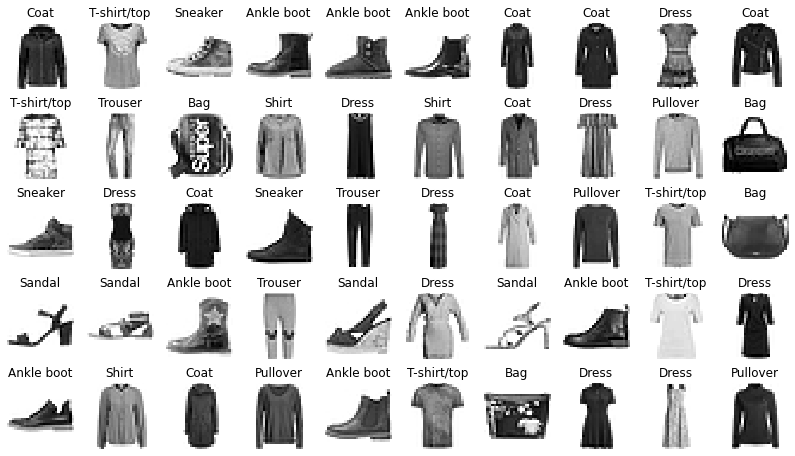

In [4]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

### [TO COMPLETE] Input Normalization:

When using Gradient Descent, it is usually a good idea to ensure that all the features have a similar scale. Try to standardize the pixel values.

In [5]:
#[TO COMPLETE]: define X_train_scaled, X_valid_scaled and X_test_scaled, the sets that contains 
#Hint: For each feature (pixel intensity), you must subtract the mean() of that 
#feature (across all instances, so use axis=0) and divide by its standard 
#deviation (std(), again axis=0)

# statistics on only the training set
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = [(x-mean)/std for x in X_train] #[TO COMPLETE]
X_valid = [(x-mean)/std for x in X_valid] #[TO COMPLETE]
X_test = [(x-mean)/std for x in X_test] #[TO COMPLETE]

#Add one dimension to manage the channel
X_train=tf.expand_dims(X_train, 3) 
X_valid=tf.expand_dims(X_valid, 3) 
X_test=tf.expand_dims(X_test,3)

#Make sure you compute the means and standard deviations on the training set,
#and use these statistics to scale the training set, the validation set and the
# test set

###Define the model

Let's create a simple CNN. The model will be composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2 ([MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D))
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class), and with the "softmax" activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.
Note that as 'input_shape' attribute's value in the first layer report also the third dimension that represents the channel.

In [14]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=[3,3], padding="same", activation="relu", input_shape=[28, 28,1]),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer='sgd',
              metrics=["accuracy"])


Print the model summary

In [15]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                62730     
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
_________________________________________________________________


Note that the number of parameters mostly depends on the output layers, indeed the parameter sharing techinique used by the 2D convolutional layers allows to significantly reduce the number of learnable weights.
Now we can train the model.

In [16]:
logdir = os.path.join(os.curdir, "baseline", "run_{}".format(time.time()))

callbacks = [
        keras.callbacks.TensorBoard(logdir),
        keras.callbacks.EarlyStopping(patience=5),

        #Saving the checkpoints file allows to load the "best" model when the Early 
        #stopping detect that the generalization error degrade (after 'patience' epochs)
        keras.callbacks.ModelCheckpoint("baseline_model.h5", save_best_only=True),
        ]

history = model.fit(X_train, y_train, epochs=20, batch_size=128,
                    validation_data=(X_valid, y_valid),
                    callbacks=callbacks)

Epoch 1/20
430/430 [==============================] - 24s 55ms/step - loss: 1.0414 - accuracy: 0.6819 - val_loss: 0.4962 - val_accuracy: 0.8338
Epoch 2/20
430/430 [==============================] - 24s 56ms/step - loss: 0.4877 - accuracy: 0.8331 - val_loss: 0.4255 - val_accuracy: 0.8588
Epoch 3/20
430/430 [==============================] - 21s 48ms/step - loss: 0.4234 - accuracy: 0.8526 - val_loss: 0.4030 - val_accuracy: 0.8648
Epoch 4/20
430/430 [==============================] - 20s 46ms/step - loss: 0.3932 - accuracy: 0.8638 - val_loss: 0.3777 - val_accuracy: 0.8748
Epoch 5/20
430/430 [==============================] - 21s 48ms/step - loss: 0.3721 - accuracy: 0.8711 - val_loss: 0.3697 - val_accuracy: 0.8772
Epoch 6/20
430/430 [==============================] - 20s 47ms/step - loss: 0.3605 - accuracy: 0.8740 - val_loss: 0.3593 - val_accuracy: 0.8808
Epoch 7/20
430/430 [==============================] - 21s 48ms/step - loss: 0.3438 - accuracy: 0.8783 - val_loss: 0.3584 - val_accuracy:

Plot the loss and the accuracy trends for the training and validation set. Then, compute the result on the test set.

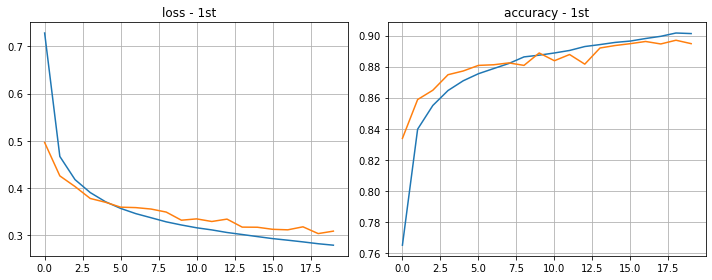

313/313 - 1s - loss: 0.3248 - accuracy: 0.8855
accuracy: 88.55%


In [17]:
def plot_loss(title, history):
    plt.figure(figsize=(5,3))
    plt.plot(history.epoch,history.history['loss'])
    plt.plot(history.epoch,history.history['val_loss'])
    plt.title("loss - "+title)
    plt.grid()

def plot_accuracy(title, history):
    plt.figure(figsize=(5,3))
    plt.plot(history.epoch,history.history['accuracy'])
    plt.plot(history.epoch,history.history['val_accuracy'])
    plt.title("accuracy - "+title)
    plt.grid()
    
def plot_loss_and_accuracy(title, history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.epoch,history.history['loss'])
    plt.plot(history.epoch,history.history['val_loss'])
    plt.title("loss - "+title)
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(history.epoch,history.history['accuracy'])
    plt.plot(history.epoch,history.history['val_accuracy'])
    plt.title("accuracy - "+title)
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
plot_loss_and_accuracy("1st", history)

scores = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))



###Visualize Weights

An interesting thing to do is to visualize the learned weights for the convolutional layer. We have 32 kernels of size 3x3, we can just plot them as images, mapping the weight values to grayscale.

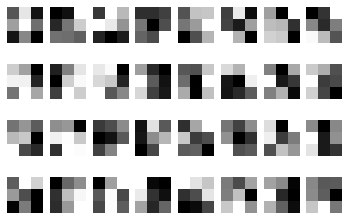

In [18]:
# Weights for the first convolutional layer
w0=model.get_weights()[0][:,:,0,:]

# Normalize to range 0.0 - 1.0
w0-=np.min(w0)
w0/=np.max(w0)

for r in range(4):
    for c in range(8):
        n=r*8+c
        plt.subplot(4, 8, n+1)
        plt.imshow(w0[:,:,n], interpolation='none')
        plt.axis('off')
        plt.gray()
plt.show()

They might be a bit hard to interpret, but it seems that the various filters have learned to detect various corners and edges.

### [TO COMPLETE] Deep CNN
Let's consider a deeper model, more precily in this exercise we consider a model composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2 
* One 2D convolutional layer with kernel size 2x2 and 16 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class), and with the "softmax" activation function


In [19]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=[3,3], activation='relu', input_shape=[28, 28,1]),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Conv2D(filters=16, kernel_size=[2,2], activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
  ])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
  
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 16)        2064      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5770      
Total params: 8,154
Trainable params: 8,154
Non-trainable params: 0
____________________________________________________

[TO COMPLETE] Explain in this cell: 

1.   how the number of parameters on each of the two Conv2D layers is determined;
2.   the reasons why the two considered convolutional layers have a different number of parameters.

Answers:


1.   The number of parameters of each layer is given by number of trainable weights. In a CNN, these are the number of weights in the kernal and the bias parameter. In the first layer, the kernal size is set at 3x3. With the input dimension of 28x28x1 (1 depth), we get a final kernal dimension of 3x3x1. With a bias parameter this sums to 3x3x1 + 1 = 10 parameters per filter. So with 32 filters, we get (3x3x1 + 1)x32 = 320. Similarly, we see the second layer has a 2x2 kernal size, where each input (from the previous activation) is 26x26x32 (32 depth), giving a final kernal dimension of 2x2x32. With a bias parameter this sums to 2x2x32 + 1 = 129 parameters per filter. So with 16 filters, we get (3x3x1 + 1)x16 = 2064 parameters.


2.   The input into the first convolutional is of dimension 28x28x1. However, the input into the second layer - or the output from the first layer - is of shape 26x26x32. Since the last kernal dimension has to match the depth of the input, we see that the despite the relatively similar number of filters (32 and 16) and kernal sizes (3x3 and 2x2) in the first and second layers - the third dimensions of the kernals are 1 and 32, which leads to the large difference in parameters per filter. This is seen in 32x(3x3x1) = 288 parameters (without 32 bias params) in the first layer versus 16x(2x2x32) = 2048 parameters (without 16 bias params) in the second. 

Let's now train our deep CNN.

Epoch 1/20
430/430 [==============================] - 27s 61ms/step - loss: 1.5300 - accuracy: 0.4800 - val_loss: 0.6811 - val_accuracy: 0.7612
Epoch 2/20
430/430 [==============================] - 28s 64ms/step - loss: 0.6597 - accuracy: 0.7637 - val_loss: 0.5620 - val_accuracy: 0.8062
Epoch 3/20
430/430 [==============================] - 25s 57ms/step - loss: 0.5690 - accuracy: 0.7970 - val_loss: 0.5180 - val_accuracy: 0.8188
Epoch 4/20
430/430 [==============================] - 21s 50ms/step - loss: 0.5103 - accuracy: 0.8191 - val_loss: 0.4781 - val_accuracy: 0.8396
Epoch 5/20
430/430 [==============================] - 22s 52ms/step - loss: 0.4838 - accuracy: 0.8325 - val_loss: 0.4587 - val_accuracy: 0.8414
Epoch 6/20
430/430 [==============================] - 23s 53ms/step - loss: 0.4534 - accuracy: 0.8410 - val_loss: 0.4399 - val_accuracy: 0.8506
Epoch 7/20
430/430 [==============================] - 23s 53ms/step - loss: 0.4393 - accuracy: 0.8443 - val_loss: 0.4233 - val_accuracy:

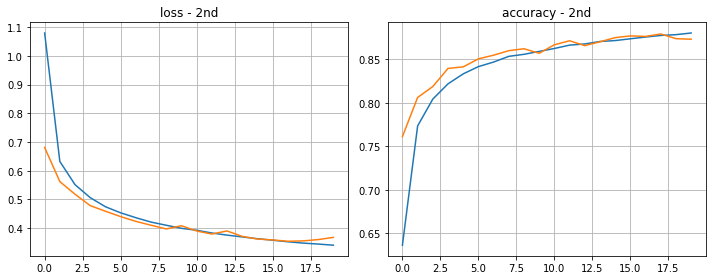

313/313 - 1s - loss: 0.3888 - accuracy: 0.8642
 loss: 38.88%
 accuracy: 86.42%
----------------------------


In [20]:
logdir = os.path.join(os.curdir, "baseline2", "run_{}".format(time.time()))

callbacks = [
        keras.callbacks.TensorBoard(logdir),
        keras.callbacks.EarlyStopping(patience=5),

        #Saving the checkpoints file allows to load the "best" model when the Early 
        #stopping detect that the generalization error degrade (after 'patience' epochs)
        keras.callbacks.ModelCheckpoint("baseline_model2.h5", save_best_only=True),
        ]


history = model.fit(X_train, y_train, epochs=20, batch_size=128,
                  validation_data=(X_valid, y_valid), callbacks=callbacks)

plot_loss_and_accuracy("2nd", history)

scores = model.evaluate(X_test, y_test, verbose=2)
print(" %s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print(" %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("----------------------------")

## [TO COMPLETE] Exercise 3.2: Develop a better CNN
Let's develop a network that performs better than the very simple one above. This exercise aims to explore how much the various hyper-parameters influence the classification capability of the model. 

**[TO COMPLETE]**: Your task is to modify some of the hyper-parameters of the previous exercise's network and compare the results. At least one of the models you try should have an improvement in the test set results (generalization) over the result of the model used in the previous exercise.
In the cell below report only the code of the **best model** that you can find. In addtion, print out its result on the test set, and plot the accuracy and the loss trends in the notebook you return.
Moreover, for each setup you test, analyze and discuss the obtained results briefly in the last cells at the bottom.

Hint: Each reparameterization should change a different aspect in the network, while the rest of the parameters would stay the same. 
Example parameters to try to change (we suggest to test at least one re-parametrization for each of these categories):

*    number of layers or neurons or filters dimension
*   activation functions
*   epochs
*   batch sizes
*   optimizer, see TensorFlow documentation on [optimizers](https://https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
*   max-pooling on/off on certain layers, or pool size

For what concerns the optimizer, as you can see in the 'compile' method [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) is it possible to pass as 'optimizer ' attribute's value a string (the name of optimizer) or an optimizer instance.

Notice that changing the final layer's softmax activation plus the categorical_crossentropy loss requires some consideration. Don't do it unless you have a good plan.

In [21]:
count_to_description = {} # count: description
models = {} # description: model
model_histories = {} # description: history
model_score = {} # description: test_accuracy
count = 1

Epoch 1/50
430/430 [==============================] - 259s 601ms/step - loss: 1.1907 - accuracy: 0.7385 - val_loss: 0.4668 - val_accuracy: 0.8678
Epoch 2/50
430/430 [==============================] - 228s 531ms/step - loss: 0.4561 - accuracy: 0.8651 - val_loss: 0.4160 - val_accuracy: 0.8750
Epoch 3/50
430/430 [==============================] - 209s 486ms/step - loss: 0.4007 - accuracy: 0.8797 - val_loss: 0.4085 - val_accuracy: 0.8772
Epoch 4/50
430/430 [==============================] - 157s 365ms/step - loss: 0.3729 - accuracy: 0.8895 - val_loss: 0.3735 - val_accuracy: 0.8880
Epoch 5/50
430/430 [==============================] - 152s 355ms/step - loss: 0.3608 - accuracy: 0.8940 - val_loss: 0.3574 - val_accuracy: 0.8926
Epoch 6/50
430/430 [==============================] - 635s 1s/step - loss: 0.3411 - accuracy: 0.8979 - val_loss: 0.3582 - val_accuracy: 0.8944
Epoch 7/50
430/430 [==============================] - 4337s 10s/step - loss: 0.3265 - accuracy: 0.9029 - val_loss: 0.3479 - val

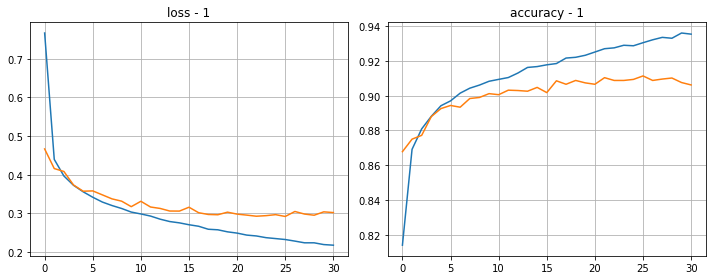

loss: 31.55
accuracy: 90.44

Done with:
Model 1: layers: 3, kernals: 3x3, filters: 64, batch: 128, opt: adam, epochs: 50, reg: True, dense: True
----------------------------


In [24]:
third_layer = [True]    
diff_n_filters = [64]    
kernal_sizes = [3]       
optimisers = ["adam"]    
batch_sizes = [128]   
epochs = [50]
regularisation = [True]
dense_layer = True

#Extras to try
# batch = 256
# opt = "RMSprop"
# pooling_on = [True, False]


model_name = ""
alpha_reg = 1e-2
for third_conv in third_layer:
    for n_filters in diff_n_filters:
        for kernal in kernal_sizes:
            for opt in optimisers:
                for batch in batch_sizes:
                    for epoch in epochs:
                        for reg in regularisation:
                
                            model_des = f"layers: {3 if third_conv else 2}, kernals: {kernal}x{kernal}, filters: {n_filters}, batch: {batch}, opt: {opt}, epochs: {epoch}, reg: {reg}, dense: {dense_layer}"
                            count_to_description[count] = model_des
                            # Build
                            if third_conv:
                                if reg:
                                    if dense_layer:
                                        model = keras.models.Sequential([
                                            keras.layers.Conv2D(filters=n_filters, kernel_size=[kernal,kernal], padding="same", activation='relu', kernel_regularizer=tf.keras.regularizers.l2(alpha_reg), input_shape=[28, 28,1]),
                                            keras.layers.Conv2D(filters=n_filters, kernel_size=[kernal,kernal], padding="same", activation='relu', kernel_regularizer=tf.keras.regularizers.l2(alpha_reg)),
                                            keras.layers.MaxPool2D(pool_size=(2,2)),
                                            keras.layers.Conv2D(filters=32, kernel_size=[kernal,kernal], padding="same", activation='relu', kernel_regularizer=tf.keras.regularizers.l2(alpha_reg)),
                                            keras.layers.MaxPool2D(pool_size=(2,2)),
                                            keras.layers.Flatten(),
                                            keras.layers.Dense(32, activation="relu"),
                                            keras.layers.Dense(10, activation="softmax")
                                          ])
                                else: 
                                    model = keras.models.Sequential([
                                        keras.layers.Conv2D(filters=n_filters, kernel_size=[kernal,kernal], padding="same", activation='relu', input_shape=[28, 28,1]),
                                        keras.layers.Conv2D(filters=n_filters, kernel_size=[kernal,kernal], padding="same", activation='relu'),
                                        keras.layers.MaxPool2D(pool_size=(2,2)),
                                        keras.layers.Conv2D(filters=32, kernel_size=[kernal,kernal], padding="same", activation='relu'),
                                        keras.layers.MaxPool2D(pool_size=(2,2)),
                                        keras.layers.Flatten(),
                                        keras.layers.Dense(10, activation="softmax")
                                      ])
                            else:
                                if reg:
                                    model = keras.models.Sequential([
                                        keras.layers.Conv2D(filters=n_filters, kernel_size=[kernal,kernal], padding="same", activation='relu', kernel_regularizer=tf.keras.regularizers.l2(alpha_reg), input_shape=[28, 28,1]),
                                        keras.layers.MaxPool2D(pool_size=(2,2)),
                                        keras.layers.Conv2D(filters=32, kernel_size=[kernal,kernal], padding="same", activation='relu', kernel_regularizer=tf.keras.regularizers.l2(alpha_reg)),
                                        keras.layers.MaxPool2D(pool_size=(2,2)),
                                        keras.layers.Flatten(),
                                        keras.layers.Dense(10, activation="softmax")
                                      ])
                                else:
                                    model = keras.models.Sequential([
                                        keras.layers.Conv2D(filters=n_filters, kernel_size=[kernal,kernal], padding="same", activation='relu', input_shape=[28, 28,1]),
                                        keras.layers.MaxPool2D(pool_size=[2,2]),
                                        keras.layers.Conv2D(filters=n_filters, kernel_size=[kernal,kernal], padding="same", activation='relu'),
                                        keras.layers.MaxPool2D(pool_size=(2,2)),
                                        keras.layers.Flatten(),
                                        keras.layers.Dense(10, activation="softmax")
                                      ])

                            model.compile(loss="sparse_categorical_crossentropy",
                                          optimizer=opt,
                                          metrics=["accuracy"])

                            logdir = os.path.join(os.curdir, "best_CNN_models", "run_{}".format(time.time()))

                            callbacks = [
                                keras.callbacks.TensorBoard(logdir),
                                keras.callbacks.EarlyStopping(patience=5),

                                #Saving the checkpoints file allows to load the "best" model when the Early 
                                #stopping detect that the generalization error degrade (after 'patience' epochs)
                                keras.callbacks.ModelCheckpoint("my_bestCNN_model.h5", save_best_only=True),
                            ]

                            #Train
                            history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch,
                                                validation_data=(X_valid, y_valid),
                                                verbose=1, callbacks=callbacks)

                            model = keras.models.load_model("my_bestCNN_model.h5")
                            model_score[model_des] = model.evaluate(X_test, y_test, verbose=2)

                            models[model_des] = model
                            model_histories[model_des] = history

                            plot_loss_and_accuracy(str(count), model_histories[model_des])    
                            print(f"{models[model_des].metrics_names[0]}: {round(model_score[model_des][0]*100,2)}")
                            print(f"{models[model_des].metrics_names[1]}: {round(model_score[model_des][1]*100,2)}")

                            print("\nDone with:")
                            print(f"Model {count}: {model_des}")
                            print("----------------------------")
                            count += 1

                        
# NOTE: 2 models below, the best is the 2nd one (difference: 1. batch_size=32 2. batch_size=128)

In [15]:
des = "layers: 3, kernals: 3x3, filters: 64, batch: 128, opt: adam, epochs: 20"
summary = models[des].summary()
print(summary)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

# Tests discussion
The best model that I found was the last model above (model 2), with parameters: 
1. 3 convolution layers and 2 pooling layers
2. 64 filters for layers 1 and 2, 32 for layer 3
3. 3x3 kernals for filter and 2x2 for pooling
4. Batch size of 128
5. Adam as optimiser
6. 13 epochs

The achieved accuracy in the test set is 91.81%.

I also tested different models, seen below:

#### Other models with over 89% test accuracy (10 epochs, with pooling layers = conv layers):
1.  Model. 5 :  layers: 2, kernals: 2, filters: 16, batch: 64. , opt: adam, pooling: True, epochs: 10
    --- Score:  accuracy: 89.21%
2.  Model. 9 :  layers: 2, kernals: 2, filters: 16, batch: 128, opt: adam, pooling: True, epochs: 10
    --- Score:  accuracy: 89.00%
3. Model 12: layers: 3, kernals: 2, filters: 32, batch: 64. ,  opt: adam, pooling: True, epochs: 10
    --- Score:  accuracy: 89.12%
4. Model 13: layers: 2, kernals: 2, filters: 32, batch: 64. ,  opt: adam, pooling: True, epochs: 10
    --- Score:  accuracy: 89.63%
5. Model 17: layers: 2, kernals: 2, filters: 32, batch: 128, opt: adam, pooling: True, epochs: 10
    --- Score:  accuracy: 89.81%
6. Model 21: layers: 2, kernals: 3, filters: 16, batch: 64. ,  opt: adam, pooling: True, epochs: 10
    --- Score:  accuracy: 89.58%
7. Model 25: layers: 2, kernals: 3, filters: 16, batch: 128, opt: adam, pooling: True, epochs: 10
    --- Score:  accuracy: 89.38%
8. Model 28: layers: 3, kernals: 3, filters: 32, batch: 64. ,  opt: adam, pooling: True, epochs: 10
    --- Score:  accuracy: 89.87%
9. Model 29: layers: 2, kernals: 3, filters: 32, batch: 64. , opt: adam, pooling: True, epochs: 10
    --- Score:  accuracy: 90.97%
10. Model 32: layers: 3, kernals: 3, filters: 32, batch: 128, opt: adam, pooling: True, epochs: 10
    --- Score:  accuracy: 89.85%
11. Model 33: layers: 2, kernals: 3, filters: 32, batch: 128, opt: adam, pooling: True, epochs: 10
    --- Score:  accuracy: 90.55%


#### The other best models
Try out 64 filters, batch size of 32 or more epochs:
    
1. Model 1: layers: 2, kernals: 3x3, filters: 64, batch: 32, opt: adam, epochs: 10
    --- Score:  accuracy: 91.56%
2. Model 2: layers: 2, kernals: 3x3, filters: 64, batch: 32, opt: adam, epochs: 15
    --- Score:  accuracy: 90.22%
3. Model 3: layers: 2, kernals: 3x3, filters: 32, batch: 128, opt: adam, epochs: 10
    --- Score:  accuracy: 90.58%
4. Model 4: layers: 2, kernals: 3x3, filters: 32, batch: 32, opt: adam, epochs: 10
    --- Score:  accuracy: 90.92%
5. Model 5: layers: 2, kernals: 3x3, filters: 64 with 32, batch: 32, opt: adam, epochs: 10
    --- Score:  accuracy: 91.10%

## Discussion:

One of the design choices made initially when deciding models to test was that there should only be one fully-connected (dense) layer. This was made so that I could explore hyperparameters mostly related to the convolution layers in the CNN. In hindsight, I could have achieved higher accuracy with more dense layers at the expense of running time. After testing out the many different hyperparameters, there were some results that were expected while some that were not. From the models above (and others), these were some observations made with exactly 10 epochs and pooling layers=filter layers:

1. Two layers are better than three
2. Adam easily the best
3. Varying results for batch size
4. 32 filters better than 16
5. 3x3 kernal better than 2x2

Of this, I would say the results that were expected were the optimiser 'Adam' and '32 filters better than 16'.
To explain why Adam is the best optimiser, it could be because 'SGD' (without momentum) might be too slow in finding a good minimum in 10 epochs, while Adam is robust combining both adaptive learning rates and momentum and manages to find one within the 10 epochs. As for the 32 filters, we expect that the more filters we have, the more different features we can capture in our model and the better our models are at classifying images.

The kernal size of 3x3 outperforming 2x2 was initially a result that I did not expect. Yet, to give an explanation for it, I guess it could be because a 3x3 kernal is a filter centered around a point that captures the surrounding pixels, which makes sense when looking for features, while a 2x2 kernal is not centered around a point and perhaps better at capturing corners or edges. 

Similarly for the batch sizes, it seems like that a smaller batch size only accounts for a very small increase of accuracy and not always. This could be due to the weights being randomly initialised, so I would not say that the effect of batch size was very significant. I did also notice that the smaller batch sizes had a tendency to overfit much faster, which is a bit strange because there should be more noise from smaller batch sizes leading to a sort of regularisation effect (Wilson and Martinez, 2003). But perhaps, as it generates more noise, maybe the model was 'unlucky' and converged to a sharp minima. Thus in the future, a possibility would be to start with a smaller learning rate for Adamn and let it adapt itself. Another late but interesting observation was that while smaller batch sizes had slightly better accuracy for 2 layer models, larger batch sizes seemed to be slightly better for 3 layer models. However, the reason for this is slightly unclear since I expected the noise or regularisation effect to be much more valuable for more complex models.

Lastly, an unexpected observation was that, initially, 2 convolutional layers outperformed 3 convolutional layers. I suspected, like with the number of filters, that deeper would be better. Yet, despite the higher complexity, these models did not overfit, which could be a simple explanation of the poorer performance. So, exactly why two layers were better than three is slightly unclear. However, I later realised I had 3 pooling layers with the 3 convolutional layers. Running the 3 layer model later with only 2 pooling layers showed much better results than with 3 pooling layers. A guess could be that for such a small input size, 3 pooling layers would probably compress too much of the input, such that we lose too much information before the final fully connected (dense) layer. Yet, I also noted that having 3 convolutional layers compared to 2 resulted in only a small increase in performance, but significantly less loss. Testing more models with 3 convolutional layers and 2 pooling layers finally resulted in the best model shown above.

In conclusion, I tested many different models where I learnt the effects of different hyperparameters on CNNs. The hyperparameters that I focused on were the number of layers, number of filters, kernal size, batch size, optimiser and number of epochs. Of this, the hyperparameters with the biggest observed impact was the optimiser choice while the number of layers and filters were in close second. Albeit these results, once the model was nearing the best manageable, larger changes in these hyperparameters, such as increasing number of filters from 32 to 64 or adding an extra convolutional layer only resulted in marginal increases of performance, but significantly more parameters and computation time. In addition, this experiment also yielded some unexpected results, such as the question of the optimal batch size and its effect for different models. This goes to show that, just like many other things in deep learning, the best hyperparameters come from trial and error.